In [37]:
import os
import glob
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from numpy import asarray
np.set_printoptions(precision=5)#show 5 number after decimal point 

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score


In [2]:
base_dir = r"data"  # Define your base directory
label = []       # Labels for each category
images_path = [] # Paths of all images
all_images = []  # Names of all images
img_label = []   # Labels corresponding to each image

for directory in os.listdir(base_dir):
    if os.path.isdir(os.path.join(base_dir, directory)):
        label.append(directory)
        # Using glob to find all jpg, jpeg, and png files
        for img_path in glob.glob(os.path.join(base_dir, directory, '*.jpg')) + \
                        glob.glob(os.path.join(base_dir, directory, '*.jpeg')) + \
                        glob.glob(os.path.join(base_dir, directory, '*.png')):
            img_name = os.path.basename(img_path)
            all_images.append(img_name)
            images_path.append(img_path)
            img_label.append(directory)


In [45]:
def upload_data(vehicle_dir, non_vehicle_dir):
    data_in_matrix = []
    
    for img_name in tqdm(os.listdir(vehicle_dir)):
        img_path = os.path.join(vehicle_dir, img_name)
        image = Image.open(img_path)  # No conversion to 'L' here
        image_array = np.asarray(image)
        data_in_matrix.append([image_array, 1]) 

    # Upload non-vehicle images
    for img_name in tqdm(os.listdir(non_vehicle_dir)):
        img_path = os.path.join(non_vehicle_dir, img_name)
        image = Image.open(img_path)  # No conversion to 'L' here
        image_array = np.asarray(image)
        data_in_matrix.append([image_array, 0])  

    # Convert data to a NumPy array
    data_in_matrix = np.array(data_in_matrix, dtype=object)
    
    return data_in_matrix

# Define the paths
vehicles_url = r"data\vehicles"
non_vehicles_url = r"data\non-vehicles"

In [46]:
data_in_matrix = upload_data(vehicles_url, non_vehicles_url)

100%|█████████████████████████████████████████████████████████████████████████████| 8968/8968 [00:14<00:00, 606.67it/s]


In [47]:
def extract_features_labels(data):
    X = []
    y = []

    for image_array, label in data:
        X.append(image_array)
        y.append(label)

    X = np.array(X)
    y = np.array(y)

    return X, y


In [48]:
# Extract features (X) and labels (y)
mat_x, mat_y = extract_features_labels(data_in_matrix)

In [50]:
mat_x = mat_x/255.0

In [51]:
#split the data to train and test 
X_train_mat, X_test_mat, y_train_mat, y_test_mat = train_test_split(mat_x,mat_y, test_size=0.2, random_state=42)
#split the train
X_train_mat, X_val_mat, y_train_mat, y_val_mat = train_test_split(X_train_mat,y_train_mat, test_size=0.2, random_state=42)

In [3]:
img_shape = cv2.imread(images_path[0])

print(f"Labels : { label}")
print(f"Total Images : {len(all_images)}")
print(f" Images shape : {img_shape.shape}")

Labels : ['non-vehicles', 'vehicles']
Total Images : 17760
 Images shape : (64, 64, 3)


In [75]:
data =pd.DataFrame({'image':images_path,'label':img_label}) 
data

,image,label
0,data\non-vehicles\extra1.png,non-vehicles
1,data\non-vehicles\extra10.png,non-vehicles
2,data\non-vehicles\extra100.png,non-vehicles
3,data\non-vehicles\extra1000.png,non-vehicles
4,data\non-vehicles\extra1001.png,non-vehicles
...,...,...
17755,data\vehicles\right (95).png,vehicles
17756,data\vehicles\right (96).png,vehicles
17757,data\vehicles\right (97).png,vehicles
17758,data\vehicles\right (98).png,vehicles


In [76]:
data = data.sample(frac=1).reset_index()
data.head()

,index,image,label
0,941,data\non-vehicles\extra2104.png,non-vehicles
1,1316,data\non-vehicles\extra2490.png,non-vehicles
2,16805,data\vehicles\middle (214).png,vehicles
3,1289,data\non-vehicles\extra2466.png,non-vehicles
4,7761,data\non-vehicles\image3422.png,non-vehicles


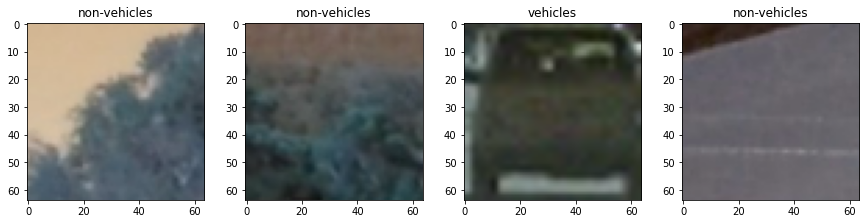

In [77]:
fig = plt.figure(figsize=(15,15))

for i in range(4):
    fig.add_subplot(4,4,i+1).set_title(data['label'][i])
    img = cv2.imread(data['image'][i])
    plt.imshow(img)
    
plt.show()

In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17760 entries, 0 to 17759
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   17760 non-null  int64 
 1   image   17760 non-null  object
 2   label   17760 non-null  object
dtypes: int64(1), object(2)
memory usage: 416.4+ KB


In [79]:
data['label'].value_counts()

non-vehicles    8968
vehicles        8792
Name: label, dtype: int64

# As we can see the data is more or less equally distributed.

In [90]:
X = data.drop('index',axis=1)
# X = X.drop('index',axis=1)
Y = data.label

In [91]:
X

,image,label
0,data\non-vehicles\extra2104.png,non-vehicles
1,data\non-vehicles\extra2490.png,non-vehicles
2,data\vehicles\middle (214).png,vehicles
3,data\non-vehicles\extra2466.png,non-vehicles
4,data\non-vehicles\image3422.png,non-vehicles
...,...,...
17755,data\non-vehicles\extra550.png,non-vehicles
17756,data\vehicles\middle (64).png,vehicles
17757,data\non-vehicles\image2496.png,non-vehicles
17758,data\vehicles\left (601).png,vehicles


In [93]:
X_train, X_final_test, y_train, y_final_test = train_test_split(X,Y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_final_test.shape)

(14208, 2)
(3552, 2)


In [95]:
y_train

15610    non-vehicles
5230     non-vehicles
15224    non-vehicles
83           vehicles
14570    non-vehicles
             ...     
11284    non-vehicles
11964        vehicles
5390     non-vehicles
860          vehicles
15795    non-vehicles
Name: label, Length: 14208, dtype: object

In [96]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 25,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [88]:
# Before we try real models, we will try a dummyClassifier. we will try to get high score than the dummyModel.
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train_mat, y_train_mat)
y_pred = dummy_clf.predict(X_val_mat)
print("The DummyClassifier score is:" ,round(accuracy_score(y_pred,y_val_mat),3))

The DummyClassifier score is: 0.497


In [66]:
# Define logistic regression model using TensorFlow 2.x
class LogisticRegression(tf.keras.Model):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.flatten = tf.keras.layers.Flatten(input_shape=(64, 64))  # Flatten input images
        self.dense = tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation

    def call(self, x):
        x = self.flatten(x)
        return self.dense(x)

# Create an instance of the logistic regression model
model = LogisticRegression()

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_mat, y_train_mat, epochs=50, batch_size=32, validation_data=(X_val_mat, y_val_mat))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_mat, y_test_mat)

print("Test Accuracy:", test_acc)

# Predictions on the test set
y_pred_prob = model.predict(X_test_mat)

# Convert probabilities to class labels based on a threshold (e.g., 0.5)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test_mat, y_pred)
print("Accuracy Score:", accuracy)

Epoch 1/50
356/356 [==============================] - 2s 3ms/step - loss: 0.3996 - accuracy: 0.8301 - val_loss: 0.2963 - val_accuracy: 0.8930
Epoch 2/50
356/356 [==============================] - 1s 3ms/step - loss: 0.3074 - accuracy: 0.8779 - val_loss: 0.2779 - val_accuracy: 0.8973
Epoch 3/50
356/356 [==============================] - 1s 3ms/step - loss: 0.2787 - accuracy: 0.8968 - val_loss: 0.2554 - val_accuracy: 0.9071
Epoch 4/50
356/356 [==============================] - 1s 2ms/step - loss: 0.2546 - accuracy: 0.9014 - val_loss: 0.2773 - val_accuracy: 0.8927
Epoch 5/50
356/356 [==============================] - 1s 3ms/step - loss: 0.2460 - accuracy: 0.9081 - val_loss: 0.2426 - val_accuracy: 0.9124
Epoch 6/50
356/356 [==============================] - 1s 2ms/step - loss: 0.2369 - accuracy: 0.9099 - val_loss: 0.2364 - val_accuracy: 0.9131
Epoch 7/50
356/356 [==============================] - 1s 2ms/step - loss: 0.2253 - accuracy: 0.9149 - val_loss: 0.2397 - val_accuracy: 0.9106
Epoch 

In [98]:
training_set = train_datagen.flow_from_dataframe(
    dataframe = X_train,
    x_col = "image",
    y_col = "label",
    target_size = (64, 64),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "training")

validation_set = train_datagen.flow_from_dataframe(
    dataframe = X_train,
    x_col = "image",
    y_col = "label",
    target_size = (64, 64),
    color_mode ="rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "validation")

test_set = test_datagen.flow_from_dataframe(
    dataframe = X_test,
    x_col = "image",
    y_col = "label",
    target_size = (64, 64),
    color_mode ="rgb",
    class_mode = "categorical",
    shuffle = False,
    batch_size = 32)

Found 11367 validated image filenames belonging to 2 classes.
Found 2841 validated image filenames belonging to 2 classes.
Found 3552 validated image filenames belonging to 2 classes.


In [99]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (64,64,3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 512, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 512, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(64, activation = "relu"))
model.add(Dense(2, activation = "softmax"))

In [100]:
model.compile(optimizer = 'adam', loss= "categorical_crossentropy", metrics=["acc"])

In [101]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=1, verbose=1)

In [102]:
history = model.fit(training_set, epochs=10,validation_data = validation_set, callbacks=[early_stopping],batch_size=32)

Epoch 1/10
356/356 [==============================] - 60s 166ms/step - loss: 0.2516 - acc: 0.8906 - val_loss: 0.1172 - val_acc: 0.9539
Epoch 2/10
356/356 [==============================] - 59s 165ms/step - loss: 0.1043 - acc: 0.9629 - val_loss: 0.0999 - val_acc: 0.9676
Epoch 3/10
356/356 [==============================] - 60s 169ms/step - loss: 0.0665 - acc: 0.9770 - val_loss: 0.0637 - val_acc: 0.9799
Epoch 4/10
356/356 [==============================] - 60s 167ms/step - loss: 0.0613 - acc: 0.9792 - val_loss: 0.0368 - val_acc: 0.9880
Epoch 5/10
356/356 [==============================] - 60s 169ms/step - loss: 0.0532 - acc: 0.9842 - val_loss: 0.0277 - val_acc: 0.9901
Epoch 6/10
356/356 [==============================] - 60s 169ms/step - loss: 0.0325 - acc: 0.9885 - val_loss: 0.0350 - val_acc: 0.9884
Epoch 6: early stopping


In [103]:
test_score = model.evaluate(test_set)

111/111 [==============================] - 6s 57ms/step - loss: 0.0266 - acc: 0.9896


In [104]:
print(f'Test Score:{test_score[1]}')
print(f'Test Loss:{test_score[0]}')

Test Score:0.9895833134651184
Test Loss:0.026605362072587013
